#This notebooks turns all zeros in each nmap in np.nan, and saves the file as a fit. Then, it takes the fits files and creates a mosaic by taking the mean, as opposed to a sum

In [2]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
from pixell import enmap, utils
from pixell import reproject
from pixell import enplot
import numpy as np
import matplotlib.pyplot as plt 
import PIL
from glob import glob
from astropy.io import fits
import time, sys
from IPython.display import clear_output
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
rc('font',size=16)

In [3]:
def progress_bar(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
        
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [4]:
# Convenient wrapper for displaying enmaps
def eshow(x,**kwargs): enplot.show(enplot.plot(x,**kwargs))

In [5]:
path = '/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2/2458098/'
fitsfiles = glob(path+'zen.*.HH.calibrated.uvh5_image/*image.image.fits')
fitsfiles.sort()

In [6]:
# Define some dimensions
fitsfile = fitsfiles[0]
# Read the map
imap = enmap.read_map(fitsfile,)
# For some reason, pixell makes it really hard to get at the actual values in the WCS header
hdu = fits.open(fitsfile)
# Define the size of the pixels in the uber-map as a fraction of the size of the original map
pix_fac = 2.
pixsize_new = np.abs(imap.wcs.pixel_scale_matrix[0][0])*60./pix_fac * utils.arcmin

Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [7]:
nmaps = len(fitsfiles)

# Need to trim mastermap ... a lot
# Figure out the extents
for ifile,fitsfile in enumerate(fitsfiles):
    print(ifile)
    progress_bar(ifile/nmaps)
    hdu = fits.open(fitsfile)
    # Extract a postage stamp centered on the center of the image
    dec0, ra0 = np.deg2rad(np.array((hdu[0].header['CRVAL2'],hdu[0].header['CRVAL1'])))
    width = np.deg2rad(20.)
    # [[decfrom,rafrom],[[decto,rato]]
    this_decfrom = dec0-width/2.
    this_rafrom = ra0-width/2.
    this_decto = dec0+width/2.
    this_rato = ra0+width/2.
    if ifile == 0:
        decfrom = this_decfrom
        rafrom = this_rafrom
        decto = this_decto
        rato = this_rato
    else:
        if this_decfrom < decfrom:
            decfrom = this_decfrom
        if this_rafrom < rafrom:
            rafrom = this_rafrom
        if this_decto > decto:
            decto = this_decto
        if this_rato > rato:
            rato = this_rato
            
print(np.rad2deg([decfrom,decto]))
print(np.rad2deg([rafrom,rato]))

Progress: [####################] 98.2%
[-40.81722485 -20.6368781 ]
[ -6.37246825 161.69223872]


In [8]:
# Define the master map
# Define its shape
shape_band, wcs_band = enmap.band_geometry(np.radians([-60,-10]), 
                                           res=pixsize_new, proj='car') #shape=shape_fullsky, proj='car')
print(shape_band)
print(wcs_band)
mastermap = enmap.enmap(np.zeros([4,1,shape_band[0],shape_band[1]]), wcs=wcs_band).submap([[decfrom,rato],[decto,rafrom]])
shape_band = mastermap.shape
wcs_band = mastermap.wcs
print(shape_band)
print(wcs_band)

(720, 5184)
WCS Transformation

This transformation has 2 pixel and 2 world dimensions

Array shape (Numpy order): None

Pixel Dim  Data size  Bounds
        0       None  None
        1       None  None

World Dim  Physical Type  Units
        0  pos.eq.ra      deg
        1  pos.eq.dec     deg

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0    1
        0  yes  yes
        1  yes  yes
(4, 1, 291, 2420)
WCS Transformation

This transformation has 2 pixel and 2 world dimensions

Array shape (Numpy order): None

Pixel Dim  Data size  Bounds
        0       None  None
        1       None  None

World Dim  Physical Type  Units
        0  pos.eq.ra      deg
        1  pos.eq.dec     deg

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0    1
        0  yes  yes
        1  yes  yes


In [9]:
nmaps = len(fitsfiles)
nfreq = 1

In [10]:
# Note the reversed order
nstokes, nfreq, ny, nx = shape_band

In [11]:
# Note that pixell wants last two trailing dimensions to be the ones associated with the WCS; 
# the others are arbitrary
pStokes = enmap.enmap(np.zeros([4,nfreq,nmaps,ny,nx]), wcs=wcs_band)
pStokes.shape

(4, 1, 56, 291, 2420)

In [12]:
matrix = np.zeros([len(fitsfiles),pStokes.shape[-2],pStokes.shape[-1]])

for ifile,fitsfile in enumerate(fitsfiles):
    progress_bar(ifile/nmaps)
    # Read file into pixell object
    imap = enmap.read_map(fitsfile,)
    stokesI = imap[0,0,:,:]
    # Extract a postage stamp centered on the center of the image
    hdu = fits.open(fitsfile)
    dec0, ra0 = np.deg2rad(np.array((hdu[0].header['CRVAL2'],hdu[0].header['CRVAL1'])))
    width = np.deg2rad(20.)
    box = np.array([[dec0-width/2.,ra0-width/2.],[dec0+width/2.,ra0+width/2.]])
 
    stamp = stokesI.submap(box)
    
    # project the stamp into the master grid
    stampmap = enmap.project(stamp, shape_band, wcs_band)
    t0 = time.time()
    for y in range(stampmap.shape[-2]):
        for x in range(stampmap.shape[-1]):
            #replace all zeros with np.nan
            if stampmap[y][x] == 0:
                stampmap[y][x] = np.nan
          
            
    #I should be taking the mean at every pixel
    t1 = time.time()
    print('Elapsed time',t1-t0,'seconds')
    
    # Store all the stamps
    matrix[ifile,:,:] = stampmap

    
    # Accumulate
    #mastermap += stampmap
#mastermap = np.nanmean(pStokes,axis=2)

Progress: [####################] 98.2%


Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Elapsed time 48.39008855819702 seconds


In [20]:
hdu = fits.PrimaryHDU(matrix)
hdu.writeto('I.fits',overwrite=True)
hdu = fits.open('I.fits')
data = hdu[0].data

In [21]:
nmaps = data.shape[0] #number of images
ny = data.shape[1] #ycoord
nx = data.shape[2] #xcoord
mastermap = enmap.enmap(np.zeros([ny,nx]), wcs=wcs_band)
for y in range(ny):
    progress_bar(y/ny)

    for x in range(nx):
        #create array that will be used to caluclate the mean at a pixel
        pixel_array = np.array([])
        for i in range(nmaps):
            #select a pixel and add it to 1D array containing nmap pixels
            pixel = data[i][y][x]
            pixel_array = np.append(pixel_array,pixel)
           
            # Once the 1D array is "full", take the nanmean and append it to mastermap
            if pixel_array.shape[0] == nmaps:
                mean_pixel = np.nanmean(pixel_array)
                mastermap[y][x] = mean_pixel

Progress: [####################] 99.7%


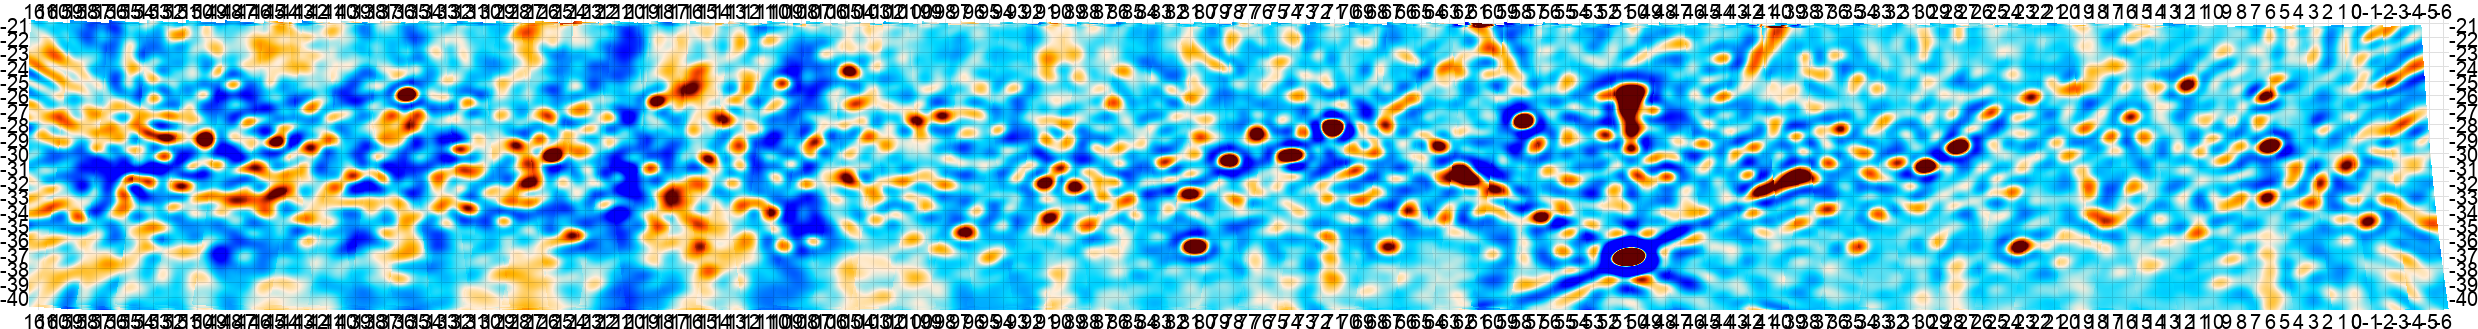

In [22]:
eshow(mastermap)